In [1]:
from matplotlib import pyplot as plt
import cv2, numpy as np, pathlib, os, PIL, PIL.Image, glob
import numpy as np
from skimage import data
from skimage import io, morphology
import tensorflow as tf
import time
from PIL import Image
import math
import timeit
import pywt
from sklearn.metrics import accuracy_score as acc, auc, f1_score
import warnings
from sklearn import metrics

width = 1024
height = 1024
dim = (width, height)
sharpen = np.array([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
])


In [36]:
for device in tf.config.list_physical_devices():
    print(": {}".format(device.name))


: /physical_device:CPU:0
: /physical_device:GPU:0
: /physical_device:GPU:1


In [93]:
m0 = np.array([[-5 ,3, 3],[-5,0,5],[-5,3,3]])
m1 = np.array([[3 ,3, 3],[-5,0,3],[-5,-5,3]])
m2 = np.array([[3 ,3, 3],[3,0,3],[-5,-5,-5]])
m3 = np.array([[3 ,3, 3],[3,0,-5],[3,-5,-5]])
m4 = np.array([[3 ,3,-5],[3,0,-5],[3,3,-5]])
m5 = np.array([[3 ,-5, -5],[3,0,-5],[3,3,3]])
m6 = np.array([[-5 ,-5, -5],[3,0,3],[3,3,3]])
m7 = np.array([[-5 ,-5, 3],[-5,0,3],[3,3,3]])

In [94]:
def calculate_target_size(img_size: int, kernel_size: int) -> int:
    num_pixels = 0
    
    # From 0 up to img size (if img size = 224, then up to 223)
    for i in range(img_size):
        # Add the kernel size (let's say 3) to the current i
        added = i + kernel_size
        # It must be lower than the image size
        if added <= img_size:
            # Increment if so
            num_pixels += 1
            
    return num_pixels


In [95]:
def convolve(img):
    
    _size = calculate_target_size(
        img_size=img.shape[0],
        kernel_size=3) #m0.shape[0]
    
    
    k = m0.shape[0]
    
    # 2D array of zeros
    convolved_img = np.zeros(shape=(width, height))
    
    # Iterate over the rows
    for i in range(_size):
        # Iterate over the columns
        for j in range(_size):
            # img[i, j] = individual pixel value
            # Get the current matrix
            
            mat = img[i:i+k, j:j+k]
            
            # Apply the convolution - element-wise multiplication and summation of the result
            # Store the result to i-th row and j-th column of our convolved_img array
            
            r0 = abs(np.sum(np.multiply(mat, m0)))
            r1 = abs(np.sum(np.multiply(mat, m1)))
            r2 = abs(np.sum(np.multiply(mat, m2)))
            r3 = abs(np.sum(np.multiply(mat, m3)))
            r4 = abs(np.sum(np.multiply(mat, m4)))
            r5 = abs(np.sum(np.multiply(mat, m5)))
            r6 = abs(np.sum(np.multiply(mat, m6)))
            r7 = abs(np.sum(np.multiply(mat, m7)))

            convolved_img[i, j] = max(r1,r2,r3,r4,r5,r6,r7)

            
    return convolved_img.astype('uint8')


In [96]:


# This function does the coefficient fusing according to the fusion method
def fuseCoeff(cooef1, cooef2, method):

    if (method == 'mean'):
        cooef = (cooef1 + cooef2 ) / 3
    # elif (method == 'min'):
    #     cooef = np.minimum(cooef1,cooef2,cooef3)
    # elif (method == 'max'):
    #     cooef = np.maximum(cooef1,cooef2,cooef3)
    # else:
    #     cooef = []

    return cooef


def FUSION(I1,I2):

    # Params
    FUSION_METHOD = 'mean' # Can be 'min' || 'max || anything you choose according theory

    # We need to have both images the same size
    # I2 = cv2.resize(I2,I1.shape) # I do this just because i used two random images

    ## Fusion algo

    # First: Do wavelet transform on each image
    wavelet = 'db1'
    cooef1 = pywt.wavedec2(I1[:,:], wavelet)
    cooef2 = pywt.wavedec2(I2[:,:], wavelet)
    # cooef3 = pywt.wavedec2(I3[:,:], wavelet)

    # Second: for each level in both image do the fusion according to the desire option
    fusedCooef = []
    for i in range(len(cooef1)-1):

        # The first values in each decomposition is the apprximation values of the top level
        if(i == 0):

            fusedCooef.append(fuseCoeff(cooef1[0],cooef2[0],FUSION_METHOD))

        else:

            # For the rest of the levels we have tupels with 2 coeeficents
            c1 = fuseCoeff(cooef1[i][0], cooef2[i][0],  FUSION_METHOD)
            c2 = fuseCoeff(cooef1[i][1], cooef2[i][1],  FUSION_METHOD)
            c3 = fuseCoeff(cooef1[i][2], cooef2[i][2], FUSION_METHOD)

            # c3 = fuseCoeff(cooef1[i][2], cooef2[i][2], cooef3[i][2], FUSION_METHOD)

            fusedCooef.append((c1,c2,c3))

    # Third: After we fused the cooefficent we nned to transfor back to get the image
    fusedImage = pywt.waverec2(fusedCooef, wavelet)

    # Forth: normmalize values to be in uint8
    fusedImage = np.multiply(np.divide(fusedImage - np.min(fusedImage),(np.max(fusedImage) - np.min(fusedImage))),255)
    fusedImage = fusedImage.astype(np.uint8)

    return fusedImage
    



In [97]:
def toimage(cleaned, mask):
    r,c = cleaned.shape
    cleaned = cleaned.astype('uint8')
    for i in range(1,r):
        for j in range(1,c):
            if cleaned[i][j]==1:
                cleaned[i][j]=255
                
    kernel = np.ones((1,1),np.uint8)
    cleaned = cv2.erode(cleaned,kernel,iterations = 1)
    kernel = np.ones((1,1),np.uint8)
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_DILATE, kernel)
    cleaned = cv2.bitwise_and(cleaned,cleaned,mask = mask)
    
    return cleaned

In [98]:
def PROCESSING(path):

    img = cv2.imread(path)
    im1 = img[:,:,1]
    im1 = cv2.resize(im1,dim, interpolation = cv2.INTER_AREA).reshape(width,height)


    clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8,8))
    enh = clahe.apply(im1)

    ret,bin = cv2.threshold(im1,18,255,cv2.THRESH_BINARY)
    kernel = np.ones((3,3),np.uint8)
    mask = cv2.erode(bin,kernel,iterations = 1)



    img = convolve(im1)

    edg = cv2.filter2D(src=img, ddepth=-1, kernel=sharpen)
    th, edg = cv2.threshold(edg, 120, 255, cv2.THRESH_BINARY )
    edg = cv2.filter2D(src=edg, ddepth=-1, kernel=sharpen)
    edg= edg>0
    edg = morphology.remove_small_objects(edg, min_size=10, connectivity=2)
    img_sharpened2 = toimage(edg,mask)


    # fusedimg = FUSION(img_sharpened2,enh)
    
    return img_sharpened2




In [37]:
data_dir = pathlib.Path('T1/IM').with_suffix('')

NR = data_dir.glob('Nr- (1).jpg')
Path = r'C:\Users\RAPTOR\Desktop\Thesis\CODE\IMG\NR_1.jpeg'

In [38]:
for i in NR:   
    print(i)
    im = PROCESSING(str(i))
    cv2.imwrite(str(Path),im)  

T1\IM\Nr- (1).jpg


In [10]:
strategy = tf.distribute.MirroredStrategy()
print('DEVICES AVAILABLE: {}'.format(strategy.num_replicas_in_sync))

DEVICES AVAILABLE: 2


In [111]:
# with tf.device('/GPU:1'):
# with strategy.scope():

data_dir = pathlib.Path('/kaggle/input/base-img/Base_PreProcess').with_suffix('')

NR = data_dir.glob('Normal/*.*')
AbNR = data_dir.glob('AbNormal/*.*')

data = []
labels = []
n=1

for i in NR:   

#   
    s = str(n)
#         Path = r'C:\Users\RAPTOR\Desktop\Thesis\CODE\Base_PreProcess\Normal\NR_'+s+'.jpeg'
#     im = PROCESSING(str(i))

#         cv2.imwrite(str(Path),im)
#         cv2.waitKey(0)
#     n+=1
    if str(i) == '/kaggle/input/base-img/Base_PreProcess/Normal/.ipynb_checkpoints':
        pass
    else:
        
#         print(str(i))
        im = cv2.imread(str(i)) 
        im = im[:,:,1]
    #     im = im.astype(np.uint8)
    #     print(type(im))

    #     break
        data.append(im)
        labels.append(0)

# n=1

for i in AbNR:   
    s = str(n)
#         Path = r'C:\Users\RAPTOR\Desktop\Thesis\CODE\Base_PreProcess\AbNormal\AbNR_'+s+'.jpeg'
#     im = PROCESSING(str(i))

#         cv2.imwrite(str(Path),im)
#         cv2.waitKey(0)
#     n+=1
    im = cv2.imread(str(i)) 
    im = im[:,:,1]
    data.append(im)
    labels.append(1)


data = np.array(data)
labels = np.array(labels)




In [12]:
def encode(labels):

    from sklearn.preprocessing import OneHotEncoder
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = labels.reshape(len(labels), 1)           #before labels_batch
    label_encoded = onehot_encoder.fit_transform(integer_encoded)
    return label_encoded


In [114]:
from sklearn.model_selection import train_test_split
X_train, X_test, ytrain, ytest = train_test_split(data, encode(labels), test_size=0.15,
                                                random_state=42)


In [28]:
import tensorflow as tf

# with strategy.scope():

def get_model(width, height):

    inputs = tf.keras.Input((width, height, 1))
    conv1 = tf.keras.layers.Conv2D(filters=16, kernel_size=5, strides=1)(inputs)
    BN1 = tf.keras.layers.BatchNormalization()(conv1)
    relu1 = tf.keras.layers.Activation(activation='relu')(BN1)

    conv2 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2,padding='same')(relu1)
    BN2 = tf.keras.layers.BatchNormalization()(conv2)
    relu2 = tf.keras.layers.Activation(activation='relu')(BN2)

    conv3 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,padding='same')(relu2)
    BN3 = tf.keras.layers.BatchNormalization()(conv3)
    relu3 = tf.keras.layers.Activation(activation='relu')(BN3)

    skipconv = tf.keras.layers.Conv2D(filters=32, kernel_size=1, strides=2)(relu1)

    Add = tf.keras.layers.Add()([skipconv,relu3])
    AvgPool = tf.keras.layers.AveragePooling2D(pool_size=(2,2), strides=2)(Add)
    FC = tf.keras.layers.Flatten()(AvgPool)

    output = tf.keras.layers.Dense(2,activation='softmax')(FC)



    model = tf.keras.Model(inputs, output,name='BASE_MODEL')

    return model





In [115]:

# Build model.
width = data[0][0].shape[0]
height = data[0][1].shape[0]

with strategy.scope():
    model = get_model(width, height)

model.summary()


Model: "BASE_MODEL"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_28 (Conv2D)             (None, 252, 252, 16  416         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_21 (BatchN  (None, 252, 252, 16  64         ['conv2d_28[0][0]']              
 ormalization)                  )                                                        

In [116]:
# model.load_weights('model.h5')

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9)

with strategy.scope():
    model.compile(
        loss="binary_crossentropy",
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        metrics=['acc',tf.keras.metrics.Precision(),
                          tf.keras.metrics.Recall()],
    )

# Define callbacks.
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "image_classification.h5", save_best_only=True
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="acc", patience=2)


epochs = 10
model.fit(
    x=X_train,
    y=ytrain,
    validation_split=0.1,
    validation_freq=5,
    epochs=epochs,
    shuffle=True,
    batch_size=128,
    
    # callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/10
4/4 [==============================] - 7s 58ms/step - loss: 0.6808 - acc: 0.6953 - precision_11: 0.6953 - recall_11: 0.6953
Epoch 2/10
4/4 [==============================] - 0s 46ms/step - loss: 0.2620 - acc: 0.9219 - precision_11: 0.9219 - recall_11: 0.9219
Epoch 3/10
4/4 [==============================] - 0s 41ms/step - loss: 0.1302 - acc: 0.9844 - precision_11: 0.9844 - recall_11: 0.9844
Epoch 4/10
4/4 [==============================] - 0s 40ms/step - loss: 0.0829 - acc: 1.0000 - precision_11: 1.0000 - recall_11: 1.0000
Epoch 5/10
4/4 [==============================] - 1s 361ms/step - loss: 0.0414 - acc: 1.0000 - precision_11: 1.0000 - recall_11: 1.0000 - val_loss: 1.7186 - val_acc: 0.6000 - val_precision_11: 0.6000 - val_recall_11: 0.6000
Epoch 6/10
4/4 [==============================] - 0s 45ms/step - loss: 0.0291 - acc: 1.0000 - precision_11: 1.0000 - recall_11: 1.0000
Epoch 7/10
4/4 [==============================] - 0s 42ms/step - loss: 0.0176 - acc: 1.0000 - precisi

In [117]:
pred = model.predict(X_test).round()
print('Model Classification report \n\n {}'.format(metrics.classification_report(ytest,pred)))
print('Model accuracy  {} %'.format(metrics.accuracy_score(ytest,pred)*100))


1/1 [==============================] - 2s 2s/step
Model Classification report 

               precision    recall  f1-score   support

           0       0.68      1.00      0.81        13
           1       1.00      0.54      0.70        13

   micro avg       0.77      0.77      0.77        26
   macro avg       0.84      0.77      0.76        26
weighted avg       0.84      0.77      0.76        26
 samples avg       0.77      0.77      0.77        26

Model accuracy  76.92307692307693 %


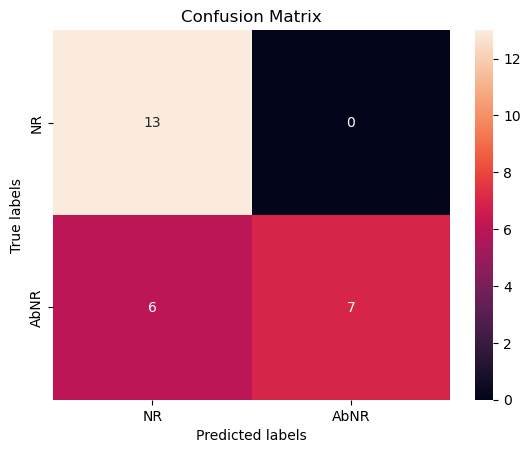

In [118]:
import seaborn as sns
class_names = ['NR','AbNR']  
ax= plt.subplot()
cm = metrics.confusion_matrix(ytest.argmax(axis=1), pred.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(class_names); ax.yaxis.set_ticklabels(class_names);


In [20]:
def toimage(cleaned, mask):
    r,c = cleaned.shape
    cleaned = cleaned.astype('uint8')
    for i in range(1,r):
        for j in range(1,c):
            if cleaned[i][j]==1:
                cleaned[i][j]=255
                
    kernel = np.ones((1,1),np.uint8)
    cleaned = cv2.erode(cleaned,kernel,iterations = 1)
    kernel = np.ones((1,1),np.uint8)
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_DILATE, kernel)
    cleaned = cv2.bitwise_and(cleaned,cleaned,mask = mask)
    
    return cleaned

def pre_process(img, NORMAL= True):
    
    # clahe = cv2.createCLAHE(clipLimit=1, tileGridSize=(3,3))
    # im1 = clahe.apply(im1)

    dst = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 9, 2)
    dst=cv2.threshold(dst, 100, 255, cv2.THRESH_OTSU )[1]
    dst = cv2.medianBlur(dst,1)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(1,1))
    dst = cv2.morphologyEx(dst, cv2.MORPH_CLOSE, kernel)


    dst = cv2.morphologyEx(dst, cv2.MORPH_CLOSE, kernel)
    dst = 255 - dst

    dst2 = cv2.morphologyEx(dst, cv2.MORPH_DILATE, kernel)


    dst2 = dst > 0

    if NORMAL:

        cleaned = morphology.remove_small_objects(dst2, min_size=120) #For Normal = 120
        cleaned = morphology.remove_small_holes(cleaned, 2)
    
    else:
        
        cleaned = morphology.remove_small_objects(dst2, min_size=40) #For Abnormal = 40
        cleaned = morphology.remove_small_holes(cleaned, 2)
        
    return cleaned
    
    



In [21]:
def PROCESSING(path):

    img = cv2.imread(path)
    im1 = img[:,:,1]
    im1 = cv2.resize(im1,dim, interpolation = cv2.INTER_AREA).reshape(width,height)

    clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8,8))
    enh = clahe.apply(im1)

    ret,bin = cv2.threshold(im1,18,255,cv2.THRESH_BINARY)
    kernel = np.ones((3,3),np.uint8)
    mask = cv2.erode(bin,kernel,iterations = 1)

    img = pre_process(im1) 
    img = toimage(img,mask)

    fusedimg = FUSION(img,enh)
    
    return fusedimg




In [22]:
data_dir = pathlib.Path('/kaggle/input/images/IMG').with_suffix('')

NR = data_dir.glob('NR/*.*')
AbNR = data_dir.glob('AbNR/*.*')

data2 = []
labels2 = []
n=1

for i in NR:   
    
    s = str(n)
#     Path = r'C:\Users\RAPTOR\Desktop\Thesis\CODE\PRO_IMG\Normal\NR_'+s+'.jpeg'
    im = PROCESSING(str(i))
    
#     cv2.imwrite(str(Path),im)
#     cv2.waitKey(0)
    n+=1
    data2.append(im)
    labels2.append(0)
    
n=1
    
for i in AbNR:   
    s = str(n)
#     Path = r'C:\Users\RAPTOR\Desktop\Thesis\CODE\PRO_IMG\AbNormal\AbNR_'+s+'.jpeg'
    im = PROCESSING(str(i))
    
#     cv2.imwrite(str(Path),im)
#     cv2.waitKey(0)
    n+=1
    data2.append(im)
    labels2.append(1)
    

data2 = np.array(data2)
labels2 = np.array(labels2)




In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, ytrain, ytest = train_test_split(data2, encode(labels2), test_size=0.15,
                                                random_state=42)


In [44]:

# Build model.
width = data2[0][0].shape[0]
height = data2[0][1].shape[0]

with strategy.scope():
# with tf.device('/GPU:0'):
    model2 = get_model(width, height)

model2.summary()

Model: "BASE_MODEL"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 508, 508, 16  416         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_15 (BatchN  (None, 508, 508, 16  64         ['conv2d_20[0][0]']              
 ormalization)                  )                                                        

In [55]:
# model.load_weights('model.h5')

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9)

with strategy.scope():

    model2.compile(
        loss="binary_crossentropy",
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        metrics=['acc',tf.keras.metrics.Precision(),
                          tf.keras.metrics.Recall()],
    )

# Define callbacks.
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "image_classification-2.h5", save_best_only=True
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="acc", patience=4)


epochs = 10
model2.fit(
    x=X_train,
    y=ytrain,
    validation_split=0.1,
    validation_freq=5,
    epochs=epochs,
    shuffle=True,
    batch_size=128,
    
#     callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/10
4/4 [==============================] - 7s 198ms/step - loss: 4.2153e-08 - acc: 1.0000 - precision_9: 1.0000 - recall_9: 1.0000
Epoch 2/10
4/4 [==============================] - 1s 142ms/step - loss: 1.3789e-08 - acc: 1.0000 - precision_9: 1.0000 - recall_9: 1.0000
Epoch 3/10
4/4 [==============================] - 1s 137ms/step - loss: 8.4164e-09 - acc: 1.0000 - precision_9: 1.0000 - recall_9: 1.0000
Epoch 4/10
4/4 [==============================] - 1s 137ms/step - loss: 3.9808e-09 - acc: 1.0000 - precision_9: 1.0000 - recall_9: 1.0000
Epoch 5/10
4/4 [==============================] - 2s 766ms/step - loss: 5.5537e-09 - acc: 1.0000 - precision_9: 1.0000 - recall_9: 1.0000 - val_loss: 0.3082 - val_acc: 0.9333 - val_precision_9: 0.9333 - val_recall_9: 0.9333
Epoch 6/10
4/4 [==============================] - 1s 162ms/step - loss: 3.6269e-09 - acc: 1.0000 - precision_9: 1.0000 - recall_9: 1.0000
Epoch 7/10
4/4 [==============================] - 1s 186ms/step - loss: 4.7915e-09 - a

In [56]:
pred = model2.predict(X_test).round()
print('Model Classification report \n\n {}'.format(metrics.classification_report(ytest,pred)))
print('Model accuracy  {} %'.format(metrics.accuracy_score(ytest,pred)*100))


1/1 [==============================] - 1s 1s/step
Model Classification report 

               precision    recall  f1-score   support

           0       0.86      0.92      0.89        13
           1       0.92      0.85      0.88        13

   micro avg       0.88      0.88      0.88        26
   macro avg       0.89      0.88      0.88        26
weighted avg       0.89      0.88      0.88        26
 samples avg       0.88      0.88      0.88        26

Model accuracy  88.46153846153845 %


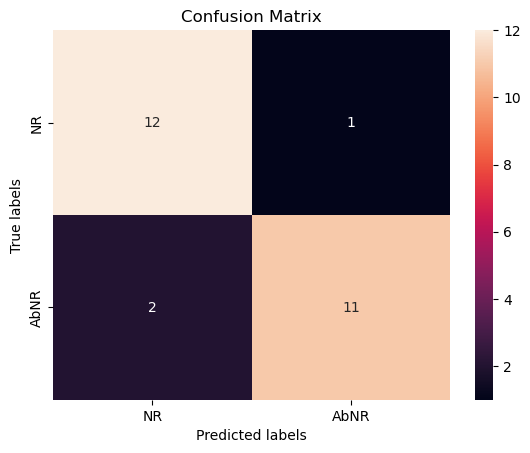

In [57]:
import seaborn as sns
class_names = ['NR','AbNR']  
ax= plt.subplot()
cm = metrics.confusion_matrix(ytest.argmax(axis=1), pred.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(class_names); ax.yaxis.set_ticklabels(class_names);


In [87]:
model2.save('model2.h5')

In [75]:


# This function does the coefficient fusing according to the fusion method
def fuseCoeff(cooef1, cooef2, method):

    if (method == 'mean'):
        cooef = (cooef1 + cooef2 ) / 3
    # elif (method == 'min'):
    #     cooef = np.minimum(cooef1,cooef2,cooef3)
    # elif (method == 'max'):
    #     cooef = np.maximum(cooef1,cooef2,cooef3)
    # else:
    #     cooef = []

    return cooef


def FUSION(I1,I2):

    # Params
    FUSION_METHOD = 'mean' # Can be 'min' || 'max || anything you choose according theory

    # We need to have both images the same size
    # I2 = cv2.resize(I2,I1.shape) # I do this just because i used two random images

    ## Fusion algo

    # First: Do wavelet transform on each image
    wavelet = 'db1'
    cooef1 = pywt.wavedec2(I1[:,:], wavelet)
    cooef2 = pywt.wavedec2(I2[:,:], wavelet)
    # cooef3 = pywt.wavedec2(I3[:,:], wavelet)

    # Second: for each level in both image do the fusion according to the desire option
    fusedCooef = []
    for i in range(len(cooef1)-1):

        # The first values in each decomposition is the apprximation values of the top level
        if(i == 0):

            fusedCooef.append(fuseCoeff(cooef1[0],cooef2[0],FUSION_METHOD))

        else:

            # For the rest of the levels we have tupels with 2 coeeficents
            c1 = fuseCoeff(cooef1[i][0], cooef2[i][0],  FUSION_METHOD)
            c2 = fuseCoeff(cooef1[i][1], cooef2[i][1],  FUSION_METHOD)
            c3 = fuseCoeff(cooef1[i][2], cooef2[i][2], FUSION_METHOD)

            # c3 = fuseCoeff(cooef1[i][2], cooef2[i][2], cooef3[i][2], FUSION_METHOD)

            fusedCooef.append((c1,c2,c3))

    # Third: After we fused the cooefficent we nned to transfor back to get the image
    fusedImage = pywt.waverec2(fusedCooef, wavelet)

    # Forth: normmalize values to be in uint8
    fusedImage = np.multiply(np.divide(fusedImage - np.min(fusedImage),(np.max(fusedImage) - np.min(fusedImage))),255)
    fusedImage = fusedImage.astype(np.uint8)

    return fusedImage
    



In [85]:
def toimage(cleaned, mask):
    r,c = cleaned.shape
    cleaned = cleaned.astype('uint8')
    for i in range(1,r):
        for j in range(1,c):
            if cleaned[i][j]==1:
                cleaned[i][j]=255
                
    kernel = np.ones((1,1),np.uint8)
    # cleaned = cv2.erode(cleaned,kernel,iterations = 1)
    kernel = np.ones((1,1),np.uint8)
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_DILATE, kernel)
    cleaned = cv2.bitwise_and(cleaned,cleaned,mask = mask)
    
    return cleaned

def pre_process(img, NORMAL= True):
    
    # clahe = cv2.createCLAHE(clipLimit=1, tileGridSize=(3,3))
    # im1 = clahe.apply(im1)

    dst = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 9, 2)
    dst=cv2.threshold(dst, 100, 255, cv2.THRESH_OTSU )[1]
    dst = cv2.medianBlur(dst,1)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(1,1))
    dst = cv2.morphologyEx(dst, cv2.MORPH_CLOSE, kernel)


    dst = cv2.morphologyEx(dst, cv2.MORPH_CLOSE, kernel)
    dst = 255 - dst

    dst2 = cv2.morphologyEx(dst, cv2.MORPH_DILATE, kernel)


    dst2 = dst > 0

    if NORMAL:

        cleaned = morphology.remove_small_objects(dst2, min_size=120) #For Normal = 120
        cleaned = morphology.remove_small_holes(cleaned, 2)
    
    else:
        
        cleaned = morphology.remove_small_objects(dst2, min_size=40) #For Abnormal = 40
        cleaned = morphology.remove_small_holes(cleaned, 2)
        
    return cleaned
    
    



In [86]:
def PROCESSING(path):
    width = 512
    height = 512
    dim = (width, height)

    img = cv2.imread(path)
    
    resized_image = cv2.resize(img, (width, height))
    
    image = resized_image.astype(np.float32) / 255.0

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    kernel = np.array([[0, -1, 0],
                       [-1, 4,-1],
                       [0, -1, 0]])
    
    laplacian = cv2.filter2D(src=gray, ddepth=-1, kernel=kernel)

    # Convert the Laplacian result back to 3 channels
    laplacian_3ch = cv2.cvtColor(laplacian, cv2.COLOR_GRAY2BGR)

    # Add the Laplacian result to the original image to obtain the sharpened image
    sharpened = cv2.add(image, laplacian_3ch)

    # Convert the image back to uint8 format
    sharpened = (sharpened * 255).clip(0, 255).astype(np.uint8)
    
    
    im1 = img[:,:,1]
    im1 = cv2.resize(im1,dim, interpolation = cv2.INTER_AREA).reshape(width,height)

    clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8,8))
    enh = clahe.apply(im1)
#     enh = cv2.cvtColor(enh, cv2.COLOR_GRAY2BGR)


    ret,bin = cv2.threshold(im1,18,255,cv2.THRESH_BINARY)
    kernel = np.ones((3,3),np.uint8)
    mask = cv2.erode(bin,kernel,iterations = 1)

    img = pre_process(im1) 
    img = toimage(img,mask)
#     img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    
    # batch = np.stack([img, enh], axis=2)
    
#     img = 255 - img

#     fusedimg = FUSION(img,enh)
    
    return img#batch #img,enh#fusedimg




In [99]:
data_dir = pathlib.Path('T1/IM').with_suffix('')

NR = data_dir.glob('Nr- (4).png')
Path = r'C:\Users\RAPTOR\Desktop\Thesis\CODE\IMG\NR_1.jpeg'

In [100]:
for i in NR:   
    print(i)
    im = PROCESSING(str(i))
    cv2.imwrite(str(Path),im)  

T1\IM\Nr- (4).png
